In [201]:
from glob import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import linear_model

import sys
sys.path.append("../") # go to parent dir
from samplers import memory_mnist

train_loader, val_loader, train_val_loader, train_labels, val_labels = memory_mnist(
    1, 32, 1, return_y=True
)

In [202]:
def calculate_coeff(data, min_i, max_i, log=False, plot=False, show=True):
    data = np.array(data)
    data_clean = data[np.all(~np.isnan(data), axis=1)]
    d, ll = tuple(zip(*data_clean))

    d = d[min_i:max_i]
    ll = ll[min_i:max_i]

    d = np.array(d).reshape(-1,1)
    ll = np.array(ll)
    
    if log:
        d = np.log(d)

    regr = linear_model.LinearRegression()
    regr.fit(d, ll)
    ll_pred = regr.predict(d)

    if plot:
        plt.plot(d, regr.predict(d), label="prediction", c='r', alpha=0.5)
        plt.plot(d, ll, 'o-', alpha=0.5)
    if show:
        plt.show()
        
    return regr.coef_[0]


In [215]:
image_size = 32
n_pixel = image_size * image_size * 1
val_flag = True

n = 50
cls = 0
for cls in range(10):
    print(cls, end=": ")
    to_plot = []
    for f in sorted(glob(f"../entropia/mnist-repaired/ll_*dataset#mnist*_{n}.*")):
        txt = pd.read_csv(f, sep=" ", header=None)
        if val_flag:
            txt = txt[val_labels.numpy() == cls]
        else:
            txt = txt[train_labels[-5000:].numpy() == cls]
        if val_flag:
            noise, pz, logdet, _, _ = txt.mean()
        else:
            noise, _, _, pz, logdet = txt.mean()
        to_plot.append([noise, -(pz + logdet)])
    to_plot = np.array(to_plot)
    coef = calculate_coeff(to_plot, 0, len(to_plot), log=True, plot=False)
    print(n_pixel - coef)
# length = 2
# dims = []
# for i in range(0, len(to_plot)-length+1):
#     coef = calculate_coeff(to_plot, i, i + length, log=True, plot=False)
#     print(i, i + length, n_pixel - coef)
#     dims.append(n_pixel - coef)
# plt.plot(np.log10((to_plot[:-1, 0] + to_plot[1:, 0])/2), dims)

0: 341.2348433338818
1: 165.91551658556057
2: 318.0079313361073
3: 307.47226264971437
4: 270.7786961183177
5: 295.38349393997214
6: 293.3311140077469
7: 249.39939985987837
8: 318.1024205586946
9: 266.4865703391181


In [216]:
txt_list = []
for f in sorted(glob(f"../entropia/mnist-repaired/ll_*dataset#mnist*_{n}.*")):
    txt = pd.read_csv(f, sep=" ", header=None)
    txt_list.append(txt)
    
dims = []
for i in range(5000):
    if i % 1000 == 0:
        print(i)
    to_plot = []
    for txt in txt_list:
        if val_flag:
            noise, pz, logdet, _, _ = txt.iloc[i]
        else:
            noise, _, _, pz, logdet = txt.iloc[i]
        to_plot.append([noise, -(pz + logdet)])
    to_plot = np.array(to_plot)
    coef = calculate_coeff(to_plot, 0, len(to_plot), log=True, plot=False, show=False)
    dims.append(n_pixel - coef)


0
1000
2000
3000
4000


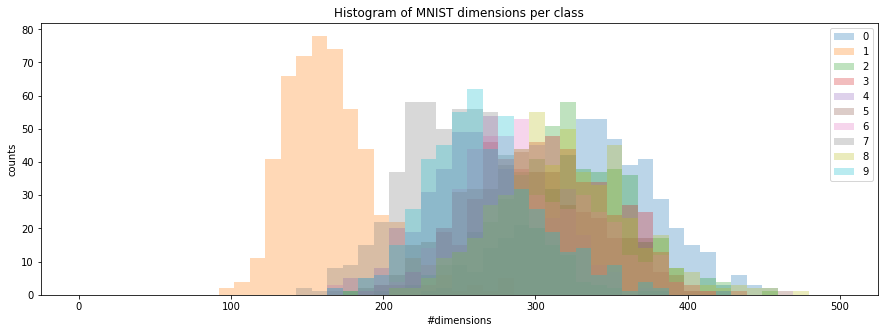

In [217]:
plt.figure(figsize=(15,5))
dims = np.array(dims)
for cls in range(10):
    if val_flag:
        plt.hist(dims[val_labels.numpy() == cls], bins=np.linspace(0, 500, 50), alpha = 0.3, label=str(cls));
    else:
        plt.hist(dims[train_labels[50000:].numpy() == cls], bins=np.linspace(0,500, 50), alpha = 0.3, label=str(cls));
#     plt.show()
plt.legend()
plt.title("Histogram of MNIST dimensions per class")
plt.xlabel("#dimensions")
plt.ylabel("counts");

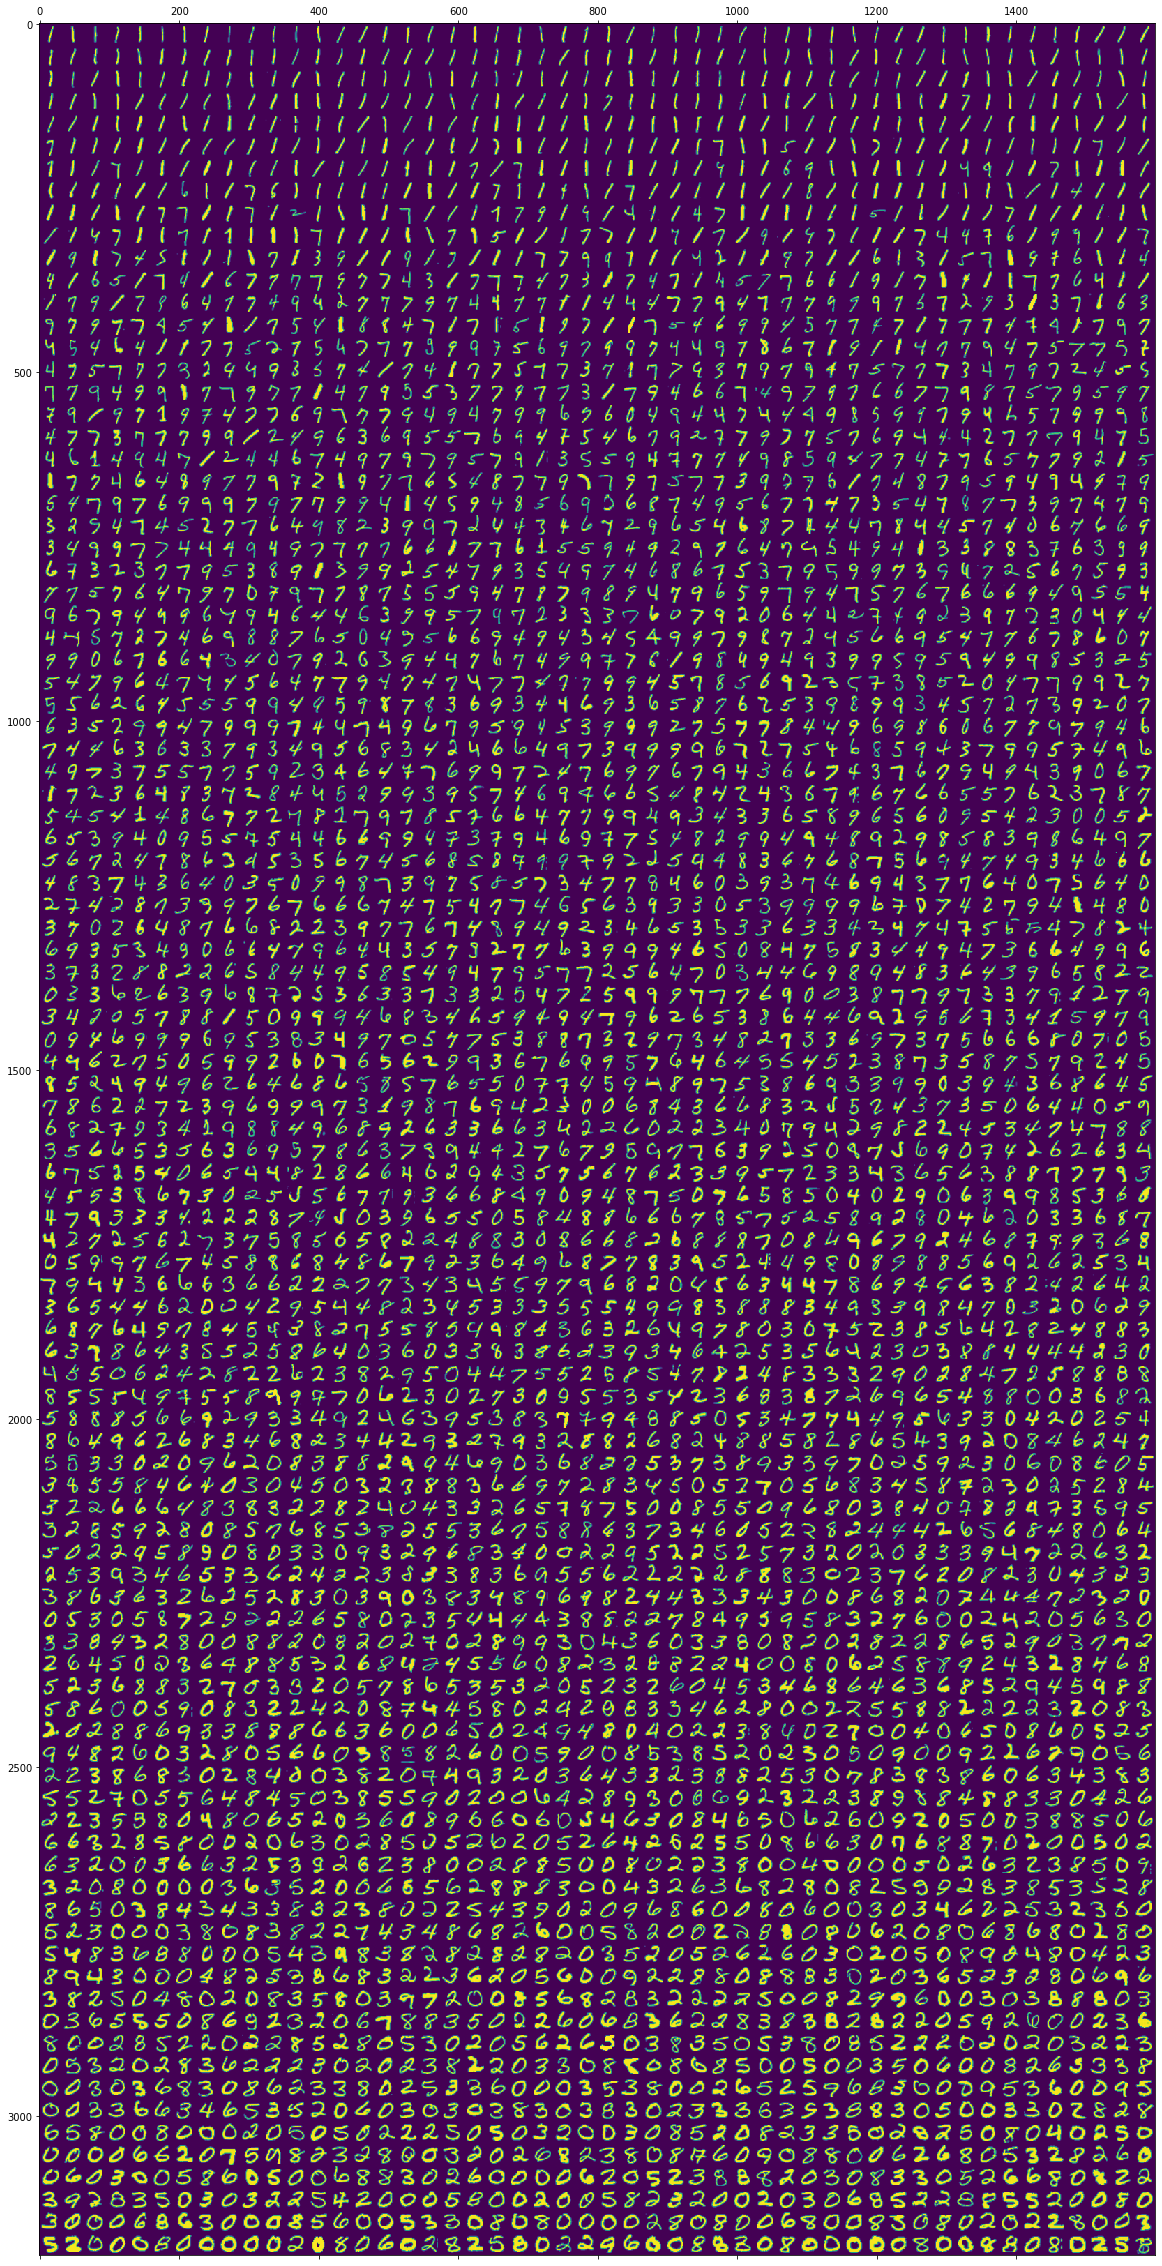

In [218]:
plt.figure(figsize=(20, 40))
m = 50
img_list = []
for i in range(0, 5000, m):
    imgs = []
    for j in range(m):
        ind = dims.argsort()[i + j]
        if val_flag:
            imgs.append(val_loader.dataset[ind][0])
        else:
            imgs.append(train_loader.dataset.tensors[50000:][ind])
    imgs = np.concatenate(imgs, axis=1)
    img_list.append(imgs)
plt.matshow(np.concatenate(img_list, axis=0), fignum=1)
plt.show()

Text(0, 0.5, '#dimensions')

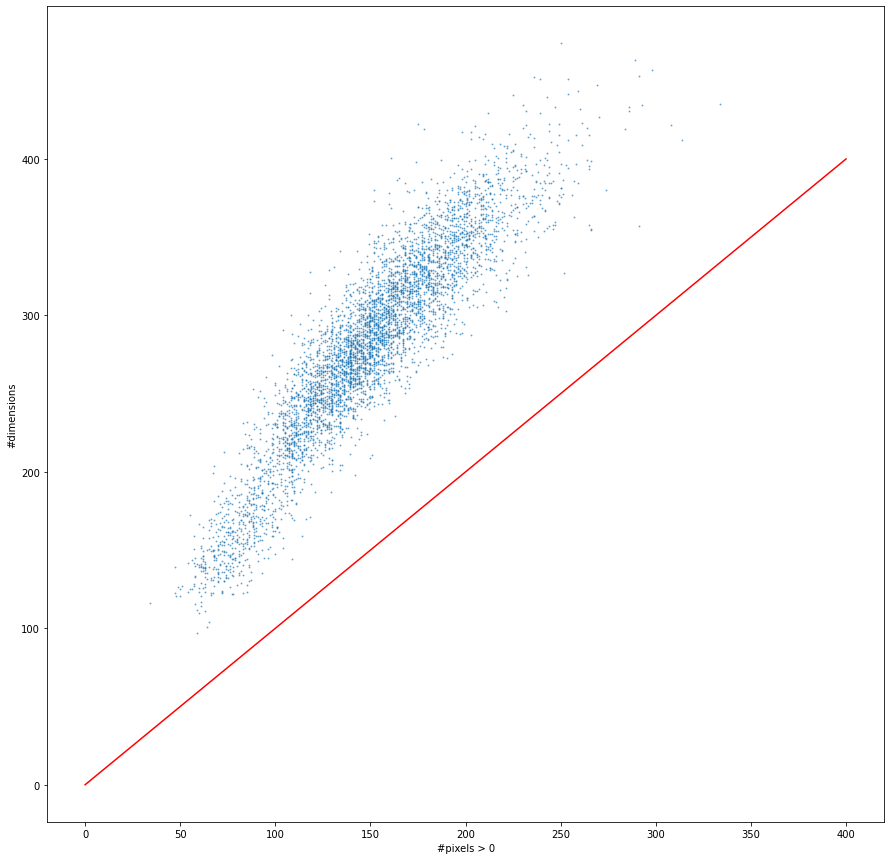

In [219]:
n_pix = []
for i in range(5000):
    n_pix.append((val_loader.dataset.tensors[i] > 0).sum().item())

plt.figure(figsize=(15,15))
plt.scatter(n_pix, dims, s=1, alpha=0.5)
plt.plot([0,400],[0,400], c='r')
plt.xlabel("#pixels > 0")
plt.ylabel("#dimensions");

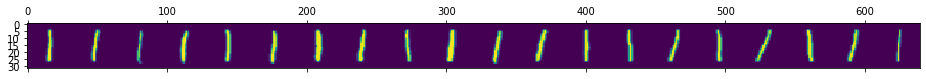

In [71]:
m = 20
imgs = []
for i in dims.argsort()[:m]:
    imgs.append(val_loader.dataset[i][0])
plt.matshow(np.concatenate(imgs, axis=1))
plt.show()

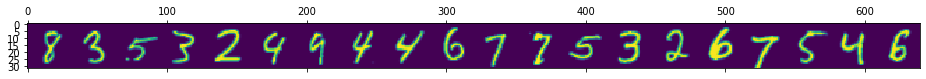

In [72]:
imgs = []
for i in dims.argsort()[2000:(2000+m)]:
    imgs.append(val_loader.dataset[i][0])
plt.matshow(np.concatenate(imgs, axis=1))
plt.show()

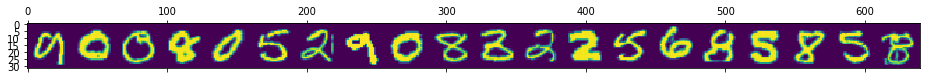

In [73]:
imgs = []
for i in dims.argsort()[-m:]:
    imgs.append(val_loader.dataset[i][0])
plt.matshow(np.concatenate(imgs, axis=1))
plt.show()

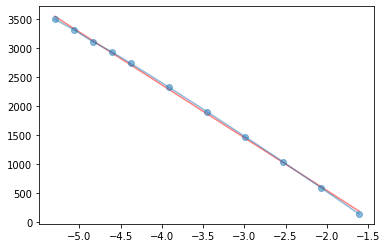

111.521148318408
0 2 251.42159448429493
1 3 117.78473188976807
2 4 258.4305566056606
3 5 160.31752375857843
4 6 133.32748065276553
5 7 110.79026299928614
6 8 88.572889129077
7 9 77.18390382805535
8 10 52.159152366686385
9 11 43.167876340500584


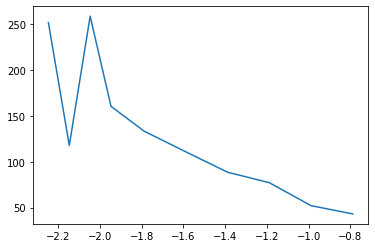

In [75]:
image_size = 32
n_pixel = image_size * image_size * 1
mul = np.log(2) * n_pixel

to_plot = []
for f in sorted(glob("../*dataset#mnist*")):
    txt = pd.read_csv(f, sep=" ", header=None)
    noise, pz, logdet = txt.mean()
    to_plot.append([noise, pz + logdet])
#     print(noise)
    
to_plot = np.array(to_plot)
to_plot[:, 1] *= mul
coef = -calculate_coeff(to_plot, 0, len(to_plot), log=True, plot=True)
print(n_pixel - coef)
length = 2
dims = []
for i in range(0, len(to_plot)-length+1):
    coef = -calculate_coeff(to_plot, i, i + length, log=True, plot=False)
    print(i, i + length, n_pixel - coef)
    dims.append(n_pixel - coef)
plt.plot(np.log10((to_plot[:-1, 0] + to_plot[1:, 0])/2), dims)

0.005000000000000004
0.0062999999999999836
0.007929999999999994
0.009990000000000027
0.012569999999999987
0.019940000000000027
0.031620000000000065
0.050150000000000035
0.07953000000000009
0.1261200000000002
0.19999999999999962


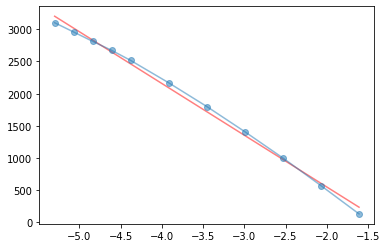

219.3277797424339
0 2 397.3868888959497
1 3 393.96758320180436
2 4 417.14284907028525
3 5 341.96363551188506
4 6 269.76994966431903
5 7 225.65243111596203
6 8 174.3474661591539
7 9 138.62056758421522
8 10 93.05690747099072
9 11 70.26847128024679


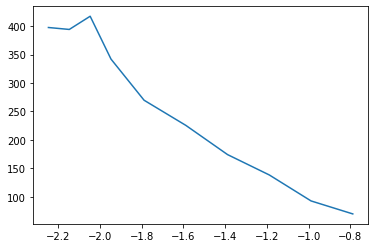

In [77]:
image_size = 32
n_pixel = image_size * image_size * 1
mul = np.log(2) * n_pixel

to_plot = []
for f in sorted(glob("../ll/*dataset#fashion_mnist*")):
#     print(f)
    txt = pd.read_csv(f, sep=" ", header=None)
    noise, pz, logdet = txt.mean()
    to_plot.append([noise, pz + logdet])
    print(noise)
    
to_plot = np.array(to_plot)
to_plot[:, 1] *= mul
coef = -calculate_coeff(to_plot, 0, len(to_plot), log=True, plot=True)
print(n_pixel - coef)
length = 2
dims = []
for i in range(0, len(to_plot)-length+1):
    coef = -calculate_coeff(to_plot, i, i + length, log=True, plot=False)
    print(i, i + length, n_pixel - coef)
    dims.append(n_pixel - coef)
plt.plot(np.log10((to_plot[:-1, 0] + to_plot[1:, 0])/2), dims)

In [30]:
32*32

1024

In [26]:
def expspace(start, end, num):
    space = np.linspace(np.log(start), np.log(end), num)
    space = np.exp(space)
    return space

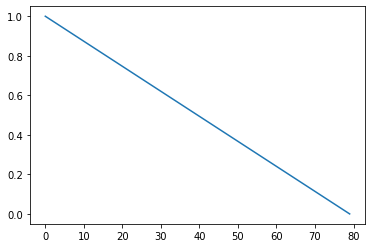

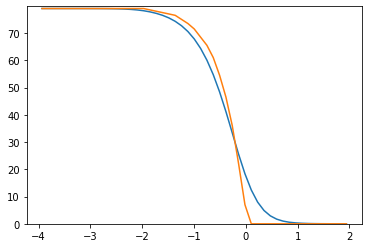

In [75]:
# sigma = [0] * 70 + [1] * 10
sigma = np.linspace(1, 0, 80)

plt.plot(sigma)
plt.show()

n_pixel = len(sigma)

to_plot = []
delta_dim  = []
for delta in expspace(0.0001, 100, 50):
    sigma = np.array(sigma)
    delta_arr = np.ones(sigma.shape[0]) * delta
    to_plot.append([delta, np.log(sigma**2 + delta_arr **2).sum()/2])
    delta_dim.append((sigma > delta).sum())
to_plot = np.array(to_plot)
delta_dim = np.array(delta_dim)

length = 2

dims = []
for i in range(0, len(to_plot)-length+1):
    coef = calculate_coeff(to_plot, i, i + length, log=True, plot=False)
#     print(i, i + length, n_pixel - coef)
    dims.append(n_pixel - coef)

plt.plot(np.log10((to_plot[:-1, 0] + to_plot[1:, 0])/2), dims)
plt.plot(np.log10((to_plot[:-1, 0] + to_plot[1:, 0])/2), (delta_dim[:-1] + delta_dim[1:])/2)
plt.ylim(0, np.max(dims) * 1.01);
# dims

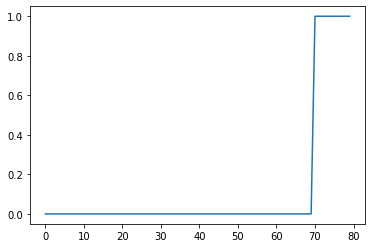

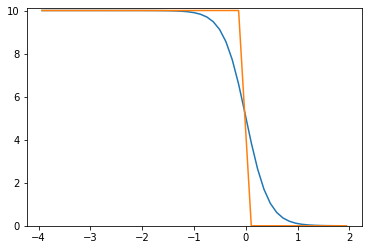

In [76]:
sigma = [0] * 70 + [1] * 10
# sigma = np.linspace(1, 0, 80)

plt.plot(sigma)
plt.show()

n_pixel = len(sigma)

to_plot = []
delta_dim  = []
for delta in expspace(0.0001, 100, 50):
    sigma = np.array(sigma)
    delta_arr = np.ones(sigma.shape[0]) * delta
    to_plot.append([delta, np.log(sigma**2 + delta_arr **2).sum()/2])
    delta_dim.append((sigma > delta).sum())
to_plot = np.array(to_plot)
delta_dim = np.array(delta_dim)

length = 2

dims = []
for i in range(0, len(to_plot)-length+1):
    coef = calculate_coeff(to_plot, i, i + length, log=True, plot=False)
#     print(i, i + length, n_pixel - coef)
    dims.append(n_pixel - coef)

plt.plot(np.log10((to_plot[:-1, 0] + to_plot[1:, 0])/2), dims)
plt.plot(np.log10((to_plot[:-1, 0] + to_plot[1:, 0])/2), (delta_dim[:-1] + delta_dim[1:])/2)
plt.ylim(0, np.max(dims) * 1.01);